# Re-calibrate cameras after movement

In [8]:
import os
from glob import glob
import cv2
import pandas as pd
import geopandas as gpd
import ast
import numpy as np
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Point

data_folder = '/Users/rdcrlrka/Research/Soo_locks'
og_image_list = sorted(glob(os.path.join(data_folder, 'inputs', 'original_images', '*.tiff')))
new_image_list = sorted(glob(os.path.join(data_folder, 'camera_calibration', 'images20251021', '*.tiff')))
print(f"Found {len(og_image_list)} images coincident and {len(new_image_list)} images not coincident with lidar.")

# Grab other input files
gcp_file = os.path.join(data_folder, 'inputs', 'gcp_new', 'GCP_merged.gpkg')
refdem_file = os.path.join(data_folder, 'inputs', 'lidar_DSM_filled_cropped.tif')
refl_file = os.path.join(data_folder, 'inputs', '20251001_Soo_Model_1cm_Intensity_UTM19N-fake.tif')
calib_file = os.path.join(data_folder, 'inputs', 'original_calibrated_cameras.csv')
water_mask_file = os.path.join(data_folder, 'inputs', 'water_mask.gpkg')

# Load merged camera calibration parameters
calib = pd.read_csv(calib_file)
for k in ['K', 'D', 'K_full', 'rvec', 'tvec']:
    calib[k] = calib[k].apply(ast.literal_eval)
calib.head()

Found 16 images coincident and 16 images not coincident with lidar.


,channel,K,D,K_full,rvec,tvec,reprojection_RMS
0,ch01,"[[2207.7228342617846, 0.0, 1902.9105058209116]...","[[-0.04194220351466015], [-0.15507988458519498...","[[1336.7286286484252, 0.0, 1891.2122147572052]...","[[3.041589020242009], [0.45589462625722443], [...","[[1.6257935293309749], [4.169718013107997], [-...",8.882362
1,ch02,"[[2041.1074274931404, 0.0, 1964.7095199483074]...","[[0.028414927555517], [0.08516766636028107], [...","[[1238.8214591862766, 0.0, 1978.6228287313738]...","[[-2.987064042682139], [-0.4440429664629578], ...","[[1.7303961210881962], [8.63973485445877], [-2...",8.611080
2,ch03,"[[4891.617851454443, 0.0, 1845.794921030038], ...","[[-2.4911660098226656], [15.872581224476486], ...","[[3251.61999170752, 0.0, 1839.504991877761], [...","[[-3.096614259468851], [-0.3721456266280592], ...","[[1.7839735059535329], [11.689302164476818], [...",14.129056
3,ch04,"[[2137.625836869759, 0.0, 1968.1684692811468],...","[[0.019874324371549526], [-0.2801219192001099]...","[[1268.2115360491746, 0.0, 1998.031435267988],...","[[-3.0134569331460876], [-0.307660224125946], ...","[[2.663526741734268], [15.75794326779889], [-1...",9.122859
4,ch05,"[[2302.446299818128, 0.0, 1890.4126693400356],...","[[0.027750053197242], [-0.4103367234639003], [...","[[1455.6233403415179, 0.0, 1873.4573451918661]...","[[3.1006035878782034], [0.34964969518269906], ...","[[2.311918306637719], [18.96598892245645], [-4...",5.460167


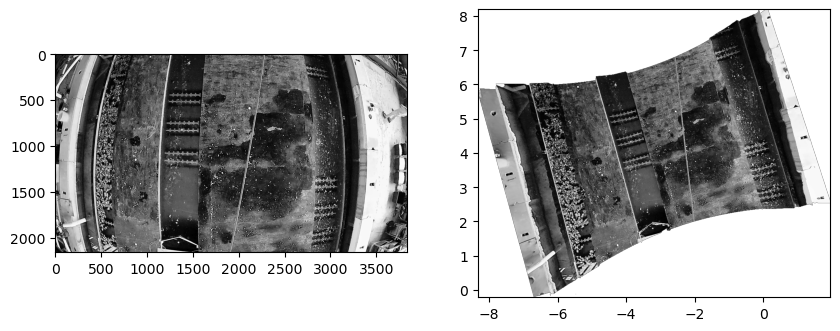

In [3]:
# --- Apply calibration to original image as a check ---
def apply_calibration(image_file, calib_params, dem_file):
    # extract calibration params
    K, D, K_full, R_rectified, t_rectified = calib_params

    # load image
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    h, w = image.shape[:2]
    dim = (int(w), int(h))

    # undistort
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K_full, dim, cv2.CV_32FC1)
    undistorted = cv2.remap(image, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

    # Mask invalid pixels
    mask = np.ones((h, w), dtype=np.uint8) * 255
    mask_undistorted = cv2.remap(mask, map1, map2, interpolation=cv2.INTER_NEAREST)
    valid_mask = mask_undistorted > 0
    undistorted = undistorted.astype(np.float32)
    undistorted[~valid_mask] = np.nan

    # Orthorectification using DEM
    # load DEM
    dem = rxr.open_rasterio(dem_file).squeeze()
    dem = xr.where(dem==-9999, np.nan, dem)
    # Build world coordinates for valid DEM pixels
    dem_z = dem.data
    X, Y = np.meshgrid(dem.x.data, dem.y.data)
    valid_dem_mask = np.isfinite(dem_z)
    world_pts = np.stack([X[valid_dem_mask], Y[valid_dem_mask], dem_z[valid_dem_mask]], axis=-1)

    # Project valid DEM points
    img_pts, _ = cv2.projectPoints(world_pts, cv2.Rodrigues(R_rectified)[0], t_rectified, K_full, np.zeros(5))
    map_x = np.full_like(dem_z, np.nan, dtype=np.float32)
    map_y = np.full_like(dem_z, np.nan, dtype=np.float32)
    map_x[valid_dem_mask] = img_pts[:, 0, 0]
    map_y[valid_dem_mask] = img_pts[:, 0, 1]

    # Remap undistorted image to DEM grid
    ortho = np.full_like(dem_z, np.nan, dtype=np.float32)
    in_bounds = (
        (map_x >= 0) & (map_x < undistorted.shape[1]) &
        (map_y >= 0) & (map_y < undistorted.shape[0])
    )
    sampled = cv2.remap(
        undistorted, 
        map_x.astype(np.float32), 
        map_y.astype(np.float32),
        interpolation=cv2.INTER_LINEAR
        )
    ortho[in_bounds] = sampled[in_bounds]
    ortho = np.where(np.isnan(dem_z), np.nan, ortho)

    # Convert to DataArray
    ortho_xr = xr.DataArray(
        data=ortho,
        dims=('y', 'x'),
        coords={'x': dem.x.data, 'y': dem.y.data}
    )

    # Drop empty rows/cols
    ortho_xr = ortho_xr.dropna(dim='x', how='all').dropna(dim='y', how='all')

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(image, cmap='Grays_r')
    ax[1].imshow(
        ortho_xr.data, cmap='Grays_r',
        extent=(min(ortho_xr.x), max(ortho_xr.x), min(ortho_xr.y), max(ortho_xr.y))
        )
    plt.show()

params = [np.array(x) for x in calib.iloc[0][['K', 'D', 'K_full', 'rvec', 'tvec']].values]
apply_calibration(
    og_image_list[0],
    params,
    refdem_file
)

## Adjust center points in new images via feature matching

In [ ]:
def undistort_image(img, K, D, K_full):
    # Undistort
    h,w = img.shape
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K_full, (w,h), cv2.CV_32FC1)
    img_undistorted = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

    # Mask invalid pixels
    # mask = np.ones((h, w), dtype=np.uint8) * 255
    # mask_undistorted = cv2.remap(mask, map1, map2, interpolation=cv2.INTER_NEAREST)
    # valid_mask = mask_undistorted > 0
    # img_undistorted = img_undistorted.astype(np.float32)
    # img_undistorted[~valid_mask] = np.nan

    return img_undistorted


def filter_mask_matches(matches, kp1, K, R, t, mask_geom, z0=-8):
    ikeep = []
    
    # Calculate matrix inverses
    K_inv = np.linalg.inv(K)
    R_inv = R.T
    C = -R_inv @ t  # camera center in world coords

    fig, ax = plt.subplots(figsize=(6,8))
    for geom in mask_geom.geoms:
        ax.plot(geom.exterior.coords.xy[0], geom.exterior.coords.xy[1], '-k')


    for i, match in enumerate(matches):
        # Pixel coordinates (u, v)
        u, v = kp1[match.queryIdx].pt
        pixel = np.array([[u], [v], [1.0]])  # shape (3,1)

        # Direction of viewing ray in world coords
        ray_dir = R_inv @ (K_inv @ pixel)
        ray_dir = ray_dir.flatten()
        ray_dir /= np.linalg.norm(ray_dir)

        # Intersect with ground z = z0
        lam = (z0 - C[2, 0]) / ray_dir[2]
        X = C.flatten() + lam * ray_dir
        xw, yw, zw = X

        # Check for intersection with mask geometry
        pt_world = Point(xw, yw)
        if mask_geom.intersects(pt_world):
            continue
        ikeep.append(i)

        ax.plot(xw,yw,'.m')

    plt.show()

    # Filter matches
    matches_filtered = [matches[i] for i in ikeep]

    return matches_filtered


def solve_new_position(
        img1_file: str = None, 
        img2_file: str = None, 
        img1_camera_params: list[np.array] = None,
        water_mask_geom = None,
        distance_threshold: int = 70
        ):
    # Load images
    img1 = cv2.imread(img1_file, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_file, cv2.IMREAD_GRAYSCALE)

    # Construct image 1 camera parameters
    K, D, K_full, Rvec, tvec = img1_camera_params

    # Convert R vector to matrix
    R1, _ = cv2.Rodrigues(np.array(Rvec))
    t1 = np.array(tvec).reshape(3, 1) # make sure shape is correct

    # Undistort images
    img1_und = undistort_image(img1, K, D, K_full)
    img2_und = undistort_image(img2, K, D, K_full)
    
    # Detect and match features 
    orb = cv2.ORB_create() 
    kp1, des1 = orb.detectAndCompute(img1_und,None) 
    kp2, des2 = orb.detectAndCompute(img2_und,None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) 
    matches = bf.match(des1, des2)

    # Filter matches over water/ice
    matches_filtered = filter_mask_matches(matches, kp1, K_full, R1, t1, water_mask_geom)
    print(len(matches), "initial matches")
    print(len(matches_filtered), "remaining matches after filtering those over water/ice")

    # Filter by distance
    print('Median match distance = ', np.nanmedian(np.array([x.distance for x in matches_filtered])))
    matches_filtered = sorted(matches_filtered, key = lambda x:x.distance)
    matches_filtered = [m for m in matches_filtered if m.distance < distance_threshold]
    print(len(matches_filtered), "remaining matches after distance filtering")

    # Draw first 10 matches.
    plt.figure(figsize=(10,6))
    img3 = cv2.drawMatches(
        img1_und, kp1, img2_und, kp2, matches_filtered[:10], None,
        matchesThickness=5, 
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
    plt.imshow(img3),plt.show()
    
    if len(matches_filtered) < 8:
        raise RuntimeError("Not enough matches left after filtering to estimate pose.")

    # Extract matched points (from undistorted images)
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches_filtered])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches_filtered])

    # Calculate Essential Matrix
    E, _ = cv2.findEssentialMat(pts1, pts2, K_full, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    if E is None:
        raise RuntimeError("Essential matrix could not be computed — insufficient inliers or poor geometry.")

    # Recover relative rotation and translation
    _, R_rel, t_rel, _ = cv2.recoverPose(E, pts1, pts2, K_full)

    # Construct the second camera
    R2 = R_rel @ R1
    tvec2 = t1 + R1.T @ t_rel  # if both cameras share the same world coordinate frame

    # Convert R matrix to vector
    rvec2, _ = cv2.Rodrigues(R2)

    return rvec2, tvec2


def orthorectify(image_file, dem_file, Rvec, tvec, K, D, K_full):
    # Undistort the image
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    img_undistorted = undistort_image(image, K, D, K_full)

    # Load DEM
    dem = rxr.open_rasterio(dem_file).squeeze()
    dem = xr.where(dem==-9999, np.nan, dem)
   
    # Build world coordinates for valid DEM pixels
    dem_z = dem.data
    X, Y = np.meshgrid(dem.x.data, dem.y.data)
    valid_dem_mask = np.isfinite(dem_z)
    world_pts = np.stack([X[valid_dem_mask], Y[valid_dem_mask], dem_z[valid_dem_mask]], axis=-1)

    # Project valid DEM points
    img_pts, _ = cv2.projectPoints(world_pts, cv2.Rodrigues(Rvec)[0], tvec, K_full, np.zeros(5))
    map_x = np.full_like(dem_z, np.nan, dtype=np.float32)
    map_y = np.full_like(dem_z, np.nan, dtype=np.float32)
    map_x[valid_dem_mask] = img_pts[:, 0, 0]
    map_y[valid_dem_mask] = img_pts[:, 0, 1]

    # Remap undistorted image to DEM grid
    ortho = np.full_like(dem_z, np.nan, dtype=np.float32)
    in_bounds = (
        (map_x >= 0) & (map_x < img_undistorted.shape[1]) &
        (map_y >= 0) & (map_y < img_undistorted.shape[0])
    )
    sampled = cv2.remap(
        img_undistorted, 
        map_x.astype(np.float32), 
        map_y.astype(np.float32),
        interpolation=cv2.INTER_LINEAR
        )
    ortho[in_bounds] = sampled[in_bounds]
    ortho = np.where(np.isnan(dem_z), np.nan, ortho)

    # Convert to DataArray
    ortho_xr = xr.DataArray(
        data=ortho,
        dims=('y', 'x'),
        coords={'x': dem.x.data, 'y': dem.y.data}
    )

    # Drop empty rows/cols
    ortho_xr = ortho_xr.dropna(dim='x', how='all').dropna(dim='y', how='all')

    return ortho_xr


water_mask = gpd.read_file(water_mask_file)
water_geom = MultiPolygon(water_mask['geometry'].values)

ch_idx = 5
calib_list = [
    calib.iloc[ch_idx]['K'], 
    calib.iloc[ch_idx]['D'], 
    calib.iloc[ch_idx]['K_full'], 
    calib.iloc[ch_idx]['R_rectified'], 
    calib.iloc[ch_idx]['t_rectified']
    ]
calib_list = [np.array(x) for x in calib_list]

rvec2, tvec2 = solve_new_position(
        og_image_list[ch_idx], 
        new_image_list[ch_idx], 
        calib_list,
        water_geom
        )

ortho2 = orthorectify(
    new_image_list[ch_idx], refdem_file, rvec2, tvec2, 
    np.array(calib.iloc[ch_idx]['K']), np.array(calib.iloc[ch_idx]['D']), np.array(calib.iloc[ch_idx]['K_full']), 
)

ortho2.plot(cmap='Grays_r')

## Try cropping to a small area around each GCP

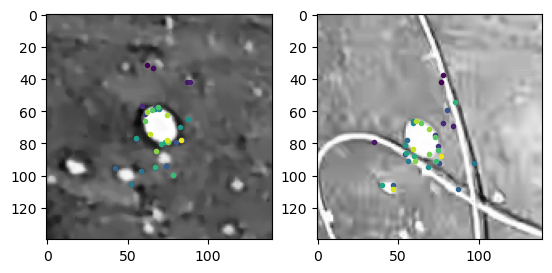

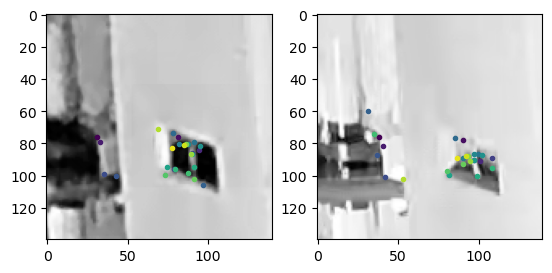

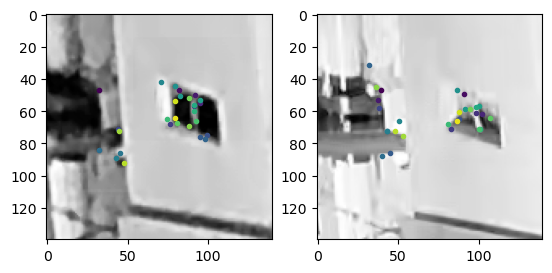

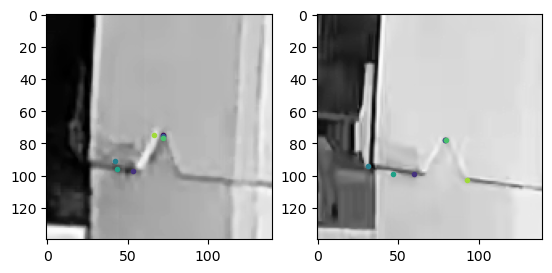

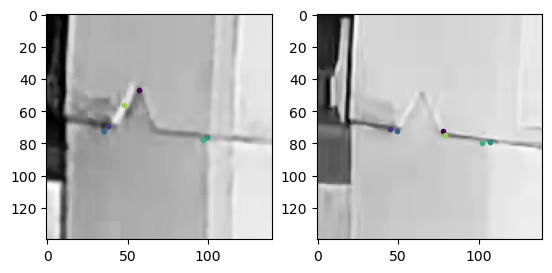

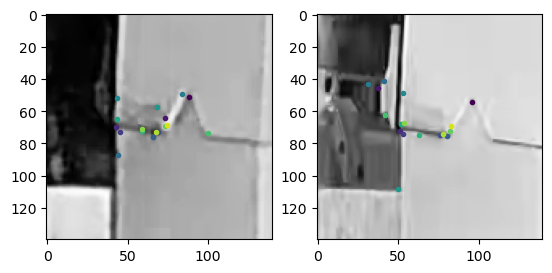

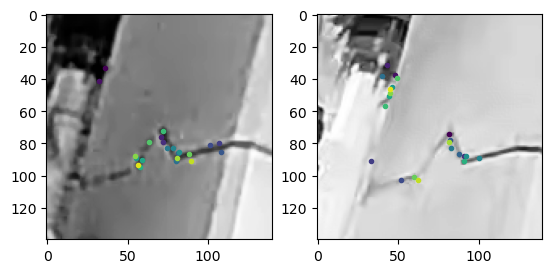

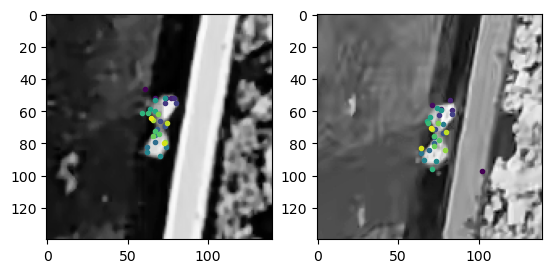

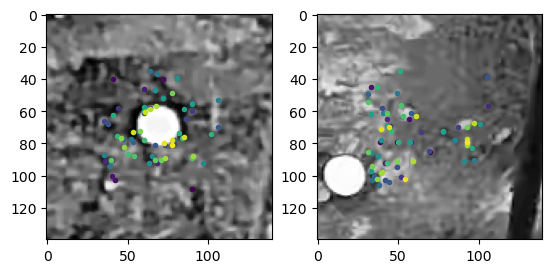

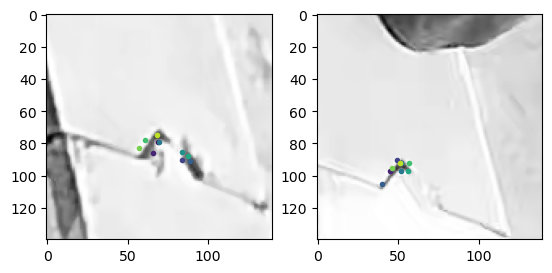

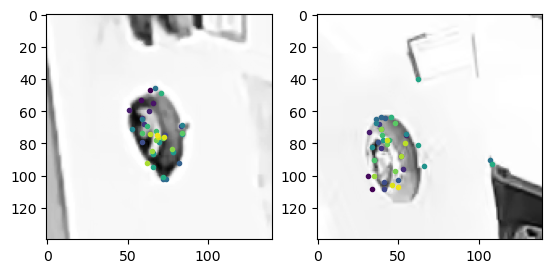

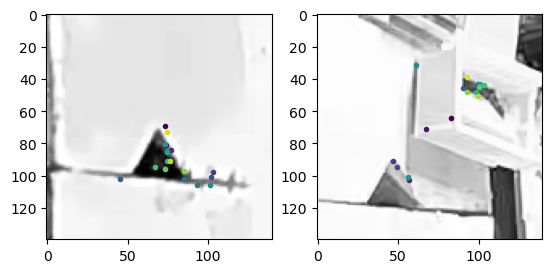

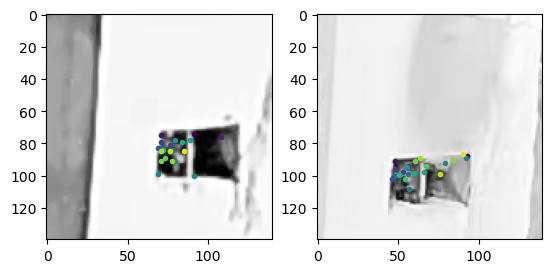

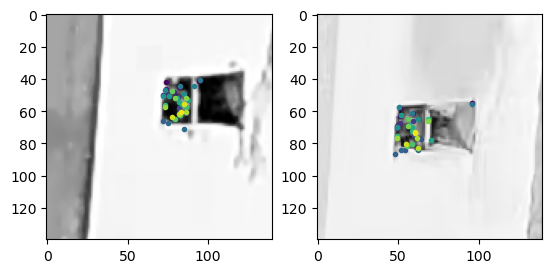

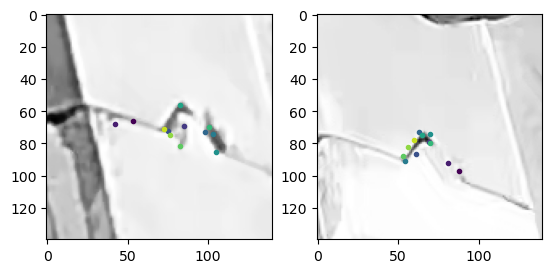

Success: True


NameError: name 'orthorectify' is not defined

In [6]:
# Load merged GCP
gcp = gpd.read_file(gcp_file, layer='gcp_merged')
gcp = gcp.dropna().reset_index(drop=True)
gcp['channel'] = [f"ch{x}" if x >= 10 else f"ch0{x}" for x in gcp['channel']]

for img1_file in og_image_list[0:1]:

    # Get second image file name
    ch = f"ch{os.path.basename(img1_file).split('ch')[1][0:2]}"
    img2_file = [x for x in new_image_list if ch in os.path.basename(x)][0]

    # Load images
    img1 = cv2.imread(img1_file, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_file, cv2.IMREAD_GRAYSCALE)

    # Get camera intrinsics
    img_calib = calib.loc[calib['channel']==ch]
    K, D, K_full = img_calib[['K', 'D', 'K_full']].values[0]
    K, D, K_full = [np.array(x) for x in (K,D,K_full)]

    # Iterate over GCP
    world_pts = []
    img_pts2 = []
    gcp_img1 = gcp.loc[gcp['channel']==ch]
    for i,gcp_row in gcp_img1.iterrows():
        col_sample, row_sample = gcp_row[['col_sample', 'row_sample']].values

        # crop images to col_sample, row_sample + a buffer
        px_buffer = 70
        col_range = int(np.round(col_sample)-px_buffer), int(np.round(col_sample)+px_buffer)
        row_range = int(np.round(row_sample)-px_buffer), int(np.round(row_sample)+px_buffer)
        img1_crop = img1[row_range[0]:row_range[1], col_range[0]:col_range[1]]
        img2_crop = img2[row_range[0]:row_range[1], col_range[0]:col_range[1]]

        # detect and match features
        orb = cv2.ORB_create() 
        kp1, des1 = orb.detectAndCompute(img1_crop,None) 
        kp2, des2 = orb.detectAndCompute(img2_crop,None)        
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) 
        try:
            matches = bf.match(des1, des2)
        except:
            continue
        if len(matches) < 4:
            continue

        # Plot good matches
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(img1_crop, cmap='Grays_r')
        ax[1].imshow(img2_crop, cmap='Grays_r')
        for i, match in enumerate(matches):
            point1 = kp1[match.queryIdx].pt
            point2 = kp2[match.trainIdx].pt
            ax[0].plot(point1[0], point1[1], '.', color=plt.cm.viridis(i/len(matches)))
            ax[1].plot(point2[0], point2[1], '.', color=plt.cm.viridis(i/len(matches)))
        plt.show()

        # Calculate average translation
        displacements = [np.array(kp2[m.trainIdx].pt) - np.array(kp1[m.queryIdx].pt) for m in matches]
        dx, dy = np.mean(displacements, axis=0)

        # Convert back to full image coordinates
        cx = col_range[0] + px_buffer
        cy = row_range[0] + px_buffer
        pt2 = np.array([cx + dx, cy + dy])
        
        # Append to lists
        img_pts2.append(pt2)
        world_pts.append([gcp_row['X'], gcp_row['Y'], gcp_row['Z']])
        
    # Convert to numpy arrays
    world_pts = np.array(world_pts, dtype=np.float32)
    img_pts2 = np.array(img_pts2, dtype=np.float32)

    # Solve for new camera pose
    success, rvec2, tvec2 = cv2.solvePnP(world_pts, img_pts2, K_full, distCoeffs=D)
    print("Success:", success)

    # orthorectify with new matrices
    ortho2 = orthorectify(img2_file, refdem_file, rvec2, tvec2, K, D, K_full)

ortho2

Initial contours = 61
Valid contours = 32
Valid, circular contours = 14


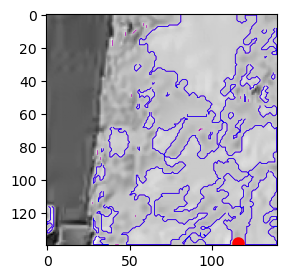

Initial contours = 2
Valid contours = 2
Valid, circular contours = 1


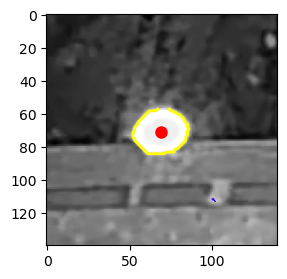

Initial contours = 1
Valid contours = 1
Valid, circular contours = 1


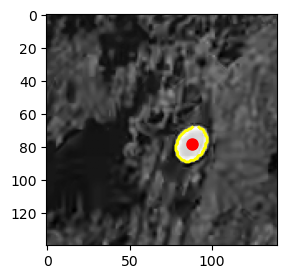

Initial contours = 1
Valid contours = 1
Valid, circular contours = 1


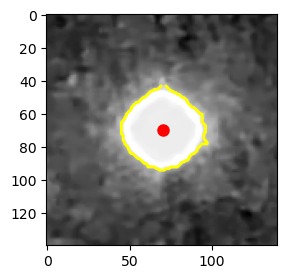

Initial contours = 2
Valid contours = 1
Valid, circular contours = 1


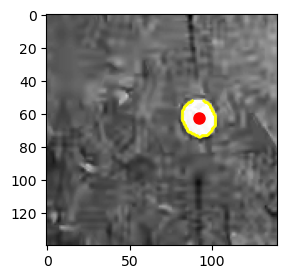

Initial contours = 3
Valid contours = 1
Valid, circular contours = 1


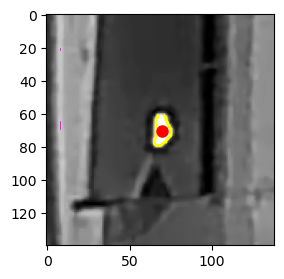

Initial contours = 37
Valid contours = 22
Valid, circular contours = 4


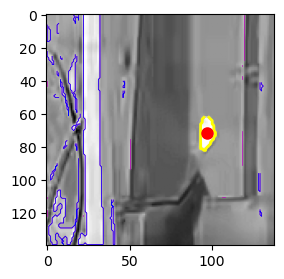

Initial contours = 1
Valid contours = 1
Initial contours = 45
Valid contours = 19
Valid, circular contours = 5


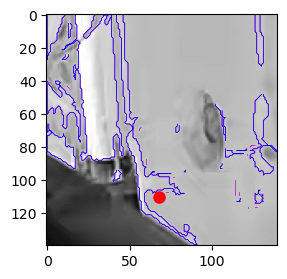

Initial contours = 4
Valid contours = 4
Initial contours = 30
Valid contours = 14
Valid, circular contours = 4


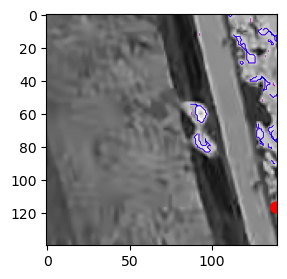

Initial contours = 28
Valid contours = 15
Valid, circular contours = 3


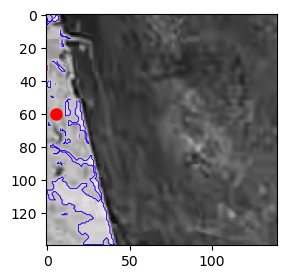

Initial contours = 5
Valid contours = 4
Initial contours = 1
Valid contours = 1
Valid, circular contours = 1


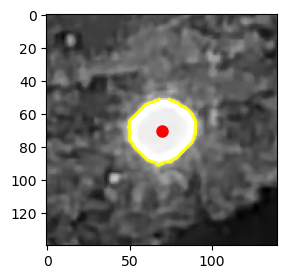

Initial contours = 12
Valid contours = 5
Valid, circular contours = 2


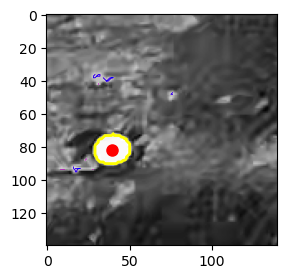

Initial contours = 13
Valid contours = 7
Valid, circular contours = 5


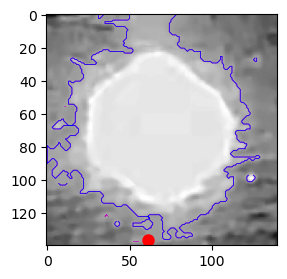

Initial contours = 3
Initial contours = 11
Valid contours = 6
Valid, circular contours = 4


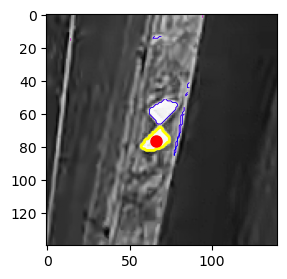

Initial contours = 4
Valid contours = 3
Valid, circular contours = 1


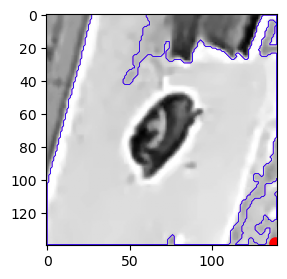

Initial contours = 2
Valid contours = 2
Valid, circular contours = 1


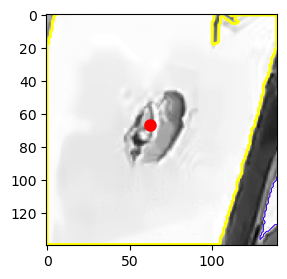

Initial contours = 6
Valid contours = 6
Valid, circular contours = 1


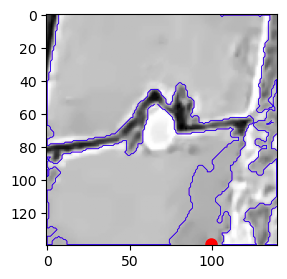

Initial contours = 4
Valid contours = 3
Valid, circular contours = 3


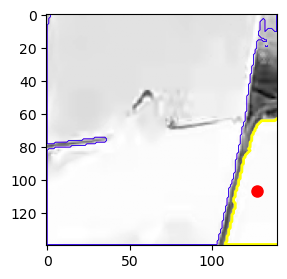

Initial contours = 1
Valid contours = 1
Initial contours = 18
Valid contours = 11
Valid, circular contours = 4


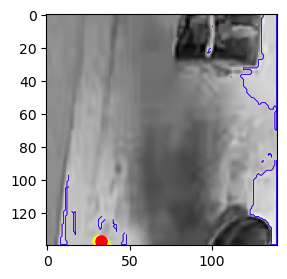

Initial contours = 1
Valid contours = 1
Valid, circular contours = 1


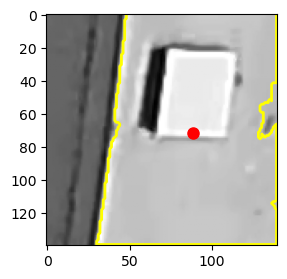

Initial contours = 12
Valid contours = 8
Valid, circular contours = 3


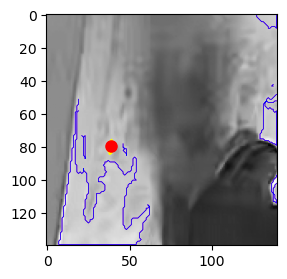

Initial contours = 10
Valid contours = 6
Valid, circular contours = 3


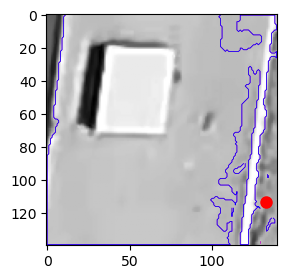

Initial contours = 9
Valid contours = 6
Valid, circular contours = 2


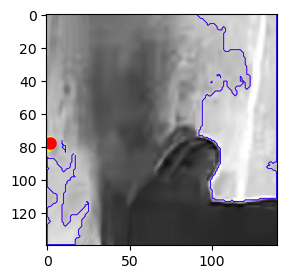

Initial contours = 8
Valid contours = 6
Valid, circular contours = 2


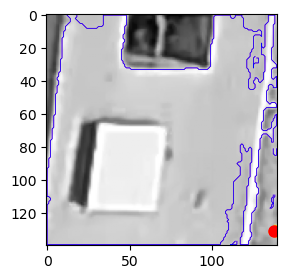

Initial contours = 11
Valid contours = 7
Valid, circular contours = 2


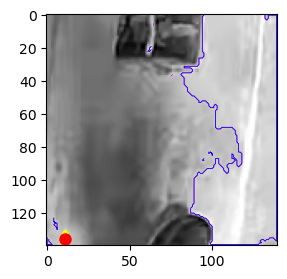

Initial contours = 8
Valid contours = 6
Valid, circular contours = 2


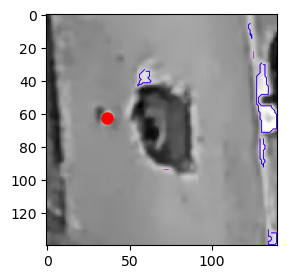

Initial contours = 25
Valid contours = 9
Valid, circular contours = 2


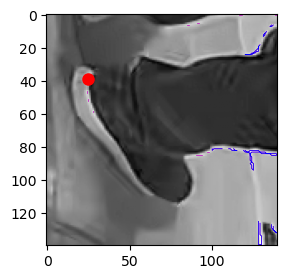

Initial contours = 15
Valid contours = 11
Valid, circular contours = 5


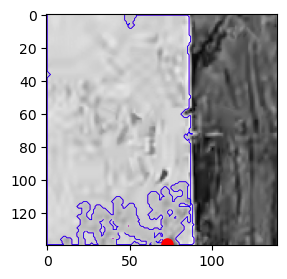

Initial contours = 5
Valid contours = 4
Valid, circular contours = 1


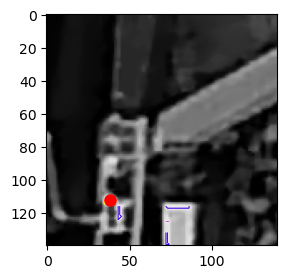

Initial contours = 51
Valid contours = 30
Valid, circular contours = 12


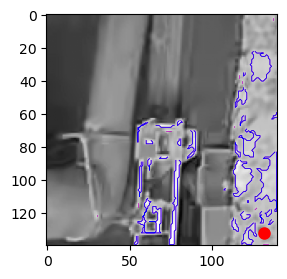

Initial contours = 8
Valid contours = 8
Valid, circular contours = 4


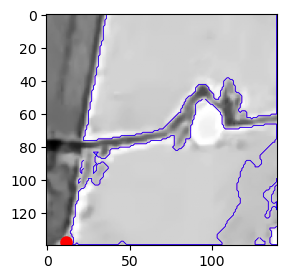

Initial contours = 3
Valid contours = 2
Initial contours = 5
Valid contours = 4
Valid, circular contours = 1


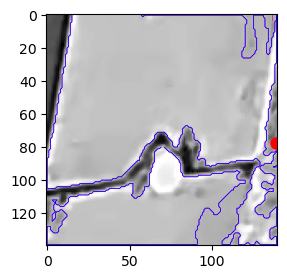

Initial contours = 4
Valid contours = 3
Valid, circular contours = 2


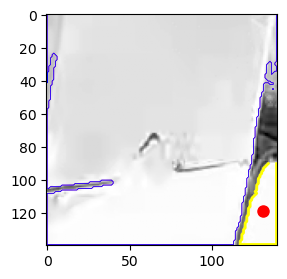

Initial contours = 12
Valid contours = 9
Valid, circular contours = 3


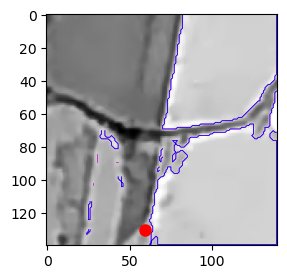

Initial contours = 17
Valid contours = 8
Valid, circular contours = 3


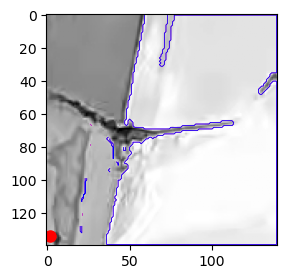

Initial contours = 6
Valid contours = 4
Valid, circular contours = 2


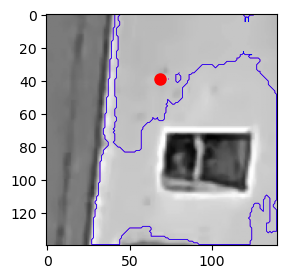

Initial contours = 10
Valid contours = 3
Initial contours = 5
Valid contours = 3
Valid, circular contours = 2


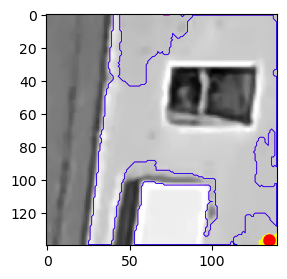

Initial contours = 15
Valid contours = 8
Valid, circular contours = 2


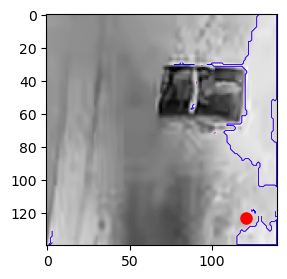

Initial contours = 21
Valid contours = 19
Valid, circular contours = 10


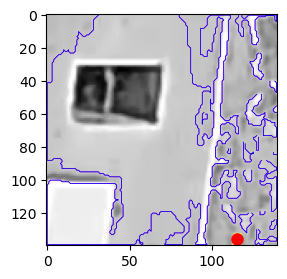

Initial contours = 15
Valid contours = 9
Valid, circular contours = 4


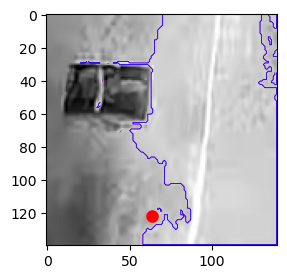

Initial contours = 19
Valid contours = 16
Valid, circular contours = 8


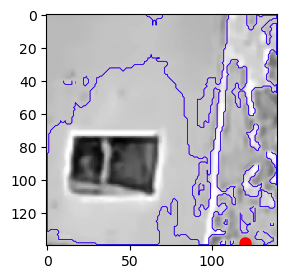

Initial contours = 9
Valid contours = 5
Initial contours = 19
Valid contours = 12
Valid, circular contours = 6


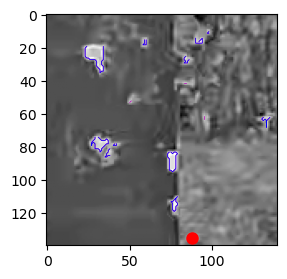

In [7]:
def detect_reflector_center(patch, threshold=200):
    """
    Detect bright circular reflector in a patch using threshold + contour centroid.
    Returns coordinates relative to patch or None if not found.
    """
    _, binary = cv2.threshold(patch, threshold, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    
    print('Initial contours =', len(contours))
    # Filter by area
    valid_contours = [c for c in contours if cv2.contourArea(c) > 0]
    if len(valid_contours) == 0:
        return None
    print('Valid contours =', len(valid_contours))

    # Filter by circularity
    valid_circular_contours = []
    for c in valid_contours:
        area = cv2.contourArea(c)
        perimeter = cv2.arcLength(c, True)
        circularity = 4 * np.pi * area / (perimeter**2)
        if circularity > 0.5:
            valid_circular_contours += [c]
    if len(valid_circular_contours) == 0:
        return None
    print('Valid, circular contours =', len(valid_circular_contours))

    # Use longest contour
    imax = np.argmax([cv2.arcLength(c,True) for x in valid_circular_contours])
    c_max = valid_circular_contours[imax]

    M = cv2.moments(c_max)
    if M['m00'] == 0:
        return None
    cx = M['m10'] / M['m00']
    cy = M['m01'] / M['m00']

    fig, ax = plt.subplots(1,1, figsize=(6,3))
    ax.imshow(patch, cmap='gray')
    for c in contours:
        c = np.array([x[0] for x in c])
        ax.plot(c[:,0], c[:,1], '-m', linewidth=0.5)
    for c in valid_contours:
        c = np.array([x[0] for x in c])
        ax.plot(c[:,0], c[:,1], '-b', linewidth=0.5)
    c_max = np.array([x[0] for x in c_max])
    ax.plot(c_max[:,0], c_max[:,1], '-', color='yellow', linewidth=2)
    ax.plot(cx, cy, 'ro', markersize=8)
    plt.show()
    
    return np.array([cx, cy])


def solve_camera_pose_from_reflectors(
        img1_file, 
        img2_file, 
        calib_row,
        gcp_df,
        px_buffer=200,
        threshold=200,
    ):
    # Load images
    img1 = cv2.imread(img1_file, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_file, cv2.IMREAD_GRAYSCALE)

    # Camera intrinsics
    K, D, K_full = np.array(calib_row['K']), np.array(calib_row['D']), np.array(calib_row['K_full'])

    world_pts = []
    img_pts2 = []

    for i, gcp_row in gcp_df.iterrows():
        row_sample, col_sample = gcp_row[['row_sample','col_sample']].values

        # crop around GCP
        col_range = np.array([int(np.round(col_sample)-px_buffer), int(np.round(col_sample)+px_buffer)])
        row_range = np.array([int(np.round(row_sample)-px_buffer), int(np.round(row_sample)+px_buffer)])
        col_range = np.sort(np.clip([int(col_sample - px_buffer), int(col_sample + px_buffer)], 0, img1.shape[1]-1))
        row_range = np.sort(np.clip([int(row_sample - px_buffer), int(row_sample + px_buffer)], 0, img1.shape[0]-1))
        img1_crop = img1[row_range[0]:row_range[1], col_range[0]:col_range[1]]
        img2_crop = img2[row_range[0]:row_range[1], col_range[0]:col_range[1]]
        
        # detect reflector centroids
        center1 = detect_reflector_center(img1_crop, threshold)
        center2 = detect_reflector_center(img2_crop, threshold)

        if center1 is None or center2 is None:
            continue  # skip if not found
            
        # Full image coordinates in img2
        pt2_full = np.array([col_range[0], row_range[0]]) + center2

        # Append to lists
        img_pts2.append(pt2_full)
        world_pts.append([gcp_row['X'], gcp_row['Y'], gcp_row['Z']])

    # Convert to numpy arrays
    if len(world_pts) < 4:
        raise RuntimeError("Not enough GCPs detected to solve for camera pose.")
    world_pts = np.array(world_pts, dtype=np.float32)
    img_pts2 = np.array(img_pts2, dtype=np.float32)

    # Solve for camera 2 pose
    success, rvec2, tvec2 = cv2.solvePnP(
        world_pts,
        img_pts2,
        K_full,
        distCoeffs=D
    )
    if not success:
        raise RuntimeError("solvePnP failed")

    return rvec2, tvec2

# Load merged GCP
gcp = gpd.read_file(gcp_file, layer='gcp_merged')
gcp = gcp.dropna().reset_index(drop=True)
gcp['channel'] = [f"ch{x}" if x >= 10 else f"ch0{x}" for x in gcp['channel']]

for i,img1_file in enumerate(og_image_list[1:2]):
    ch = f"ch{os.path.basename(img1_file).split('ch')[1][0:2]}"
    img2_file = [x for x in new_image_list if ch in os.path.basename(x)][0]
    calib_row = calib.loc[calib['channel'] == ch].iloc[0]
    gcp_df = gcp.loc[gcp['channel']==ch]
    
    rvec2, tvec2 = solve_camera_pose_from_reflectors(
        img1_file, 
        img2_file, 
        calib_row,
        gcp_df,
        px_buffer=70,
        threshold=200,
    )
